In [2]:
import sys
sys.path.append('a/UltimeTradingBot/Crypto_backtest_tools')
from utilities.get_data import get_historical_from_db
from utilities.backtesting import basic_single_asset_backtest, plot_wallet_vs_asset, get_metrics
import pandas as pd
import ccxt
import matplotlib.pyplot as plt
import ta
import json
import numpy as np
import random
from sklearn.utils import shuffle
import seaborn as sns
from utilities.backtesting import plot_wallet_vs_asset, get_metrics, get_n_columns, basic_multi_asset_backtest, plot_sharpe_evolution, plot_bar_by_month
from utilities.custom_indicators import SuperTrend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
import os
pd.options.mode.chained_assignment = None  # default='warn'


In [35]:
import gc


In [3]:

import tensorflow as tf
#tf.test.is_gpu_available(
#     cuda_only=False, min_cuda_compute_capability=None
# )
tf.config.list_physical_devices('GPU')

!nvidia-smi



Wed Sep 21 15:52:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.77       Driver Version: 512.77       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P8    N/A /  N/A |    144MiB /  4096MiB |     16%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import warnings
warnings.filterwarnings('ignore')
PRERR=False
def prerr(err):
    if PRERR:
        print("\033[0;31m Error in "+str(sys._getframe().f_code.co_name) +" \033[0;33m"+str(err))

In [5]:
#MetaData=get_crypto_metadata(Binance_USDT_HALAL)
MetaData = pd.read_csv("D:\+DATA+\MetaData.csv")
df = pd.read_csv('D:/+DATA+/allok_w15_nosell.csv',index_col=0)

In [6]:
#df=df.drop(columns="sell")
#df=df.drop(columns=["Unnamed: 0"])
#df.to_csv('D:/+DATA+/allok_w15_nosell.csv')

In [7]:
sys.getsizeof(df)/(1024**2)

6337.254440307617

## Testing impoted DATA

In [8]:
df[df['buy']==1]

,open,high,low,close,volume,high-1,low-1,open-1,close-1,volume-1,...,BTC_high-15_5min,BTC_low-15_5min,BTC_open-15_5min,BTC_close-15_5min,BTC_volume-15_5min,day,hour,minute,lunch_day,buy
5,0.259200,0.259300,0.254700,0.258000,38103.38,0.259900,0.257900,0.259000,0.259400,26573.45,...,52500.42,52066.99,52066.99,52469.49,909.313696,1,15,18,-117,1
6,0.000043,0.000043,0.000043,0.000043,47526628.00,0.000043,0.000043,0.000043,0.000043,21892392.00,...,29609.47,29536.22,29536.23,29564.50,272.084180,6,4,37,-611,1
7,0.052220,0.052220,0.052220,0.052220,218.60,0.052250,0.052240,0.052250,0.052240,814.50,...,19085.65,19052.62,19085.64,19076.30,120.363966,1,3,18,-314,1
11,3.036200,3.036200,3.008200,3.018100,101695.10,3.046600,3.035300,3.046500,3.035700,6457.70,...,39785.99,39713.50,39719.99,39767.99,125.824500,4,13,59,-741,1
17,0.287290,0.287900,0.286660,0.287710,45267.50,0.287900,0.286760,0.287350,0.287290,64389.70,...,35949.60,35861.24,35870.17,35912.68,219.663963,6,16,56,-335,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084353,5.646400,5.677400,5.612800,5.666700,30206.87,5.674200,5.577100,5.604200,5.646400,46021.36,...,50077.90,49380.14,49952.49,50037.51,816.505984,2,7,17,-223,1
1084361,2.428000,2.431000,2.424000,2.430000,1538.10,2.434000,2.425000,2.434000,2.430000,1785.40,...,38834.02,38699.99,38700.00,38815.49,82.259800,3,0,39,-638,1
1084364,1.039700,1.040300,1.035000,1.036200,1597635.57,1.042000,1.039600,1.039800,1.039700,822241.14,...,39420.77,39271.96,39296.40,39288.07,605.105036,4,11,25,607,1
1084369,0.451630,0.451630,0.449670,0.451380,10695.90,0.452800,0.451660,0.451660,0.452730,4355.60,...,35776.57,35588.00,35773.34,35605.99,198.151291,1,0,22,98,1


In [9]:
df.iloc[1000037]["buy"]

0.0

In [10]:


high_weight=3
df["high"]=(df["open"]+high_weight*df["high"]+df["low"]+df["close"])/(3+high_weight)
df.rename(columns={"high":"price"},inplace = True)
df["BTC_high"]=(df["BTC_open"]+high_weight*df["BTC_high"]+df["BTC_low"]+df["BTC_close"])/(3+high_weight)
df.rename(columns={"BTC_high":"BTC_price"},inplace = True)
df2=df.drop(columns=["BTC_open","BTC_low","BTC_close","open","low","close"])
del(df)
df=df2
#del(df2)
for key in df.keys():
    if key.find("BTC")!=-1 and (key.find("open")!=-1 or
    key.find("high")!=-1 or key.find("low")!=-1 or key.find("close")!=-1):
        df[key]=(df["BTC_price"]-df[key])/df["BTC_price"]
    if key.find("BTC")==-1 and (key.find("open")!=-1 or
    key.find("high")!=-1 or key.find("low")!=-1 or key.find("close")!=-1):
        df[key]=(df["price"]-df[key])/df["price"]

df1=df[df["buy"]==1]
df0=df[df["buy"]==0].iloc[0:len(df1)]
df=pd.concat([df1,df0],axis=0)
del(df1)
del(df0)




In [22]:
#VolRemover=["volume","volume-1","BTC_volume-1"]
VolRemover=[]
for key in df.keys():
    if key.find("volume-1_") != -1 :
        VolRemover.append(key)

df=df.drop(columns=VolRemover)

In [23]:
"volume-1_1day" in df.keys()

False

In [ ]:
for k in df.keys():print(k, end="  ; ")

In [27]:
df.keys()

Index(['price', 'high-1', 'low-1', 'open-1', 'close-1', 'high-2', 'low-2',
       'open-2', 'close-2', 'volume-2',
       ...
       'BTC_high-15_5min', 'BTC_low-15_5min', 'BTC_open-15_5min',
       'BTC_close-15_5min', 'BTC_volume-15_5min', 'day', 'hour', 'minute',
       'lunch_day', 'buy'],
      dtype='object', length=748)

In [29]:
df.to_csv("cleaned_w15_50percent_novolume.csv")

In [ ]:
try:
    df=pd.concat([df1,df0],axis=0).drop(columns=['volume-1', 'volume-1','close','BTC_volume-1', 'BTC_volume-1','BTC_volume-1'])
except:
    print("df may be clean")
    

In [30]:
del(df1)
del(df0)

NameError: name 'df1' is not defined

In [31]:
df=df.reindex(np.random.permutation(df.index))
df=df.reindex(np.random.permutation(df.index))
df=df.reindex(np.random.permutation(df.index))
sys.getsizeof(df)/(1024**2)
df


,price,high-1,low-1,open-1,close-1,high-2,low-2,open-2,close-2,volume-2,...,BTC_high-15_5min,BTC_low-15_5min,BTC_open-15_5min,BTC_close-15_5min,BTC_volume-15_5min,day,hour,minute,lunch_day,buy
263373,0.834533,-0.001039,-0.001039,-0.001039,-0.001039,-0.001278,-0.000200,-0.000559,-0.001278,2562.24000,...,-0.000472,0.000659,-0.000458,0.000374,135.739098,5,19,25,572,0
177238,0.267890,-0.003173,0.002202,-0.002949,0.000747,-0.006794,-0.001978,-0.006197,-0.002949,60725.60000,...,0.000748,0.003573,0.002551,0.000846,86.304710,2,3,17,-323,0
57208,43.761667,-0.000419,0.000267,-0.000419,0.000267,-0.000647,-0.000419,-0.000647,-0.000419,22.83194,...,-0.001683,-0.001070,-0.001370,-0.001494,115.725349,3,3,8,749,0
91407,0.000270,-0.003704,-0.003704,-0.003704,-0.003704,-0.003704,-0.003704,-0.003704,-0.003704,62671.00000,...,-0.009368,-0.006812,-0.009299,-0.006813,243.119622,3,5,4,133,0
127022,0.728150,-0.001305,0.006661,0.006249,-0.001167,0.002266,0.006523,0.006523,0.006249,208749.60000,...,-0.018855,-0.015650,-0.018256,-0.015812,111.089970,2,9,28,-351,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101366,4.099367,0.001577,0.004261,0.002529,0.001577,0.000553,0.005115,0.001309,0.002773,18340.92000,...,-0.004630,-0.002987,-0.003730,-0.003795,140.776594,1,23,1,-230,0
185226,2.403000,-0.000832,-0.000832,-0.000832,-0.000832,-0.001248,-0.000832,-0.001248,-0.000832,15.00000,...,-0.009789,-0.007048,-0.007466,-0.009034,138.743890,5,7,25,130,0
131379,1.104133,-0.001872,-0.000785,-0.001872,-0.000785,-0.002959,-0.002143,-0.002143,-0.002143,292.00000,...,-0.006039,-0.002814,-0.004780,-0.002936,212.879800,4,10,49,307,0
166187,1.356800,0.000000,0.001253,0.000663,0.000737,0.000737,0.001695,0.001474,0.000737,79354.55000,...,-0.003522,-0.001499,-0.002159,-0.002339,273.298550,2,8,35,624,0


### Remove volumes

Cheking null values

In [32]:
df[df.isnull().any(axis=1)]

,price,high-1,low-1,open-1,close-1,high-2,low-2,open-2,close-2,volume-2,...,BTC_high-15_5min,BTC_low-15_5min,BTC_open-15_5min,BTC_close-15_5min,BTC_volume-15_5min,day,hour,minute,lunch_day,buy


checking keys

In [ ]:
for k in df.keys():print(k,end="  ;")

# starting numpy process

## convert Pandas DataFrame to numpy object

In [33]:

dt = df.to_numpy()
dt


array([[ 8.34533333e-01, -1.03850455e-03, -1.03850455e-03, ...,
         2.50000000e+01,  5.72000000e+02,  0.00000000e+00],
       [ 2.67890000e-01, -3.17294412e-03,  2.20239651e-03, ...,
         1.70000000e+01, -3.23000000e+02,  0.00000000e+00],
       [ 4.37616667e+01, -4.18935903e-04,  2.66595575e-04, ...,
         8.00000000e+00,  7.49000000e+02,  0.00000000e+00],
       ...,
       [ 1.10413333e+00, -1.87175462e-03, -7.84929356e-04, ...,
         4.90000000e+01,  3.07000000e+02,  0.00000000e+00],
       [ 1.35680000e+00,  0.00000000e+00,  1.25294811e-03, ...,
         3.50000000e+01,  6.24000000e+02,  0.00000000e+00],
       [ 1.47983333e+00, -7.88377069e-04,  1.57675414e-03, ...,
         5.20000000e+01, -6.85000000e+02,  0.00000000e+00]])

In [36]:
del(df)


NameError: name 'df' is not defined

In [37]:
gc.collect()


2240

In [38]:
dt.shape

(429940, 748)

In [48]:
dt[142110,0]

5.1000000000000005

### Shuffle the rows Again

In [49]:
np.random.shuffle(dt)

In [50]:
sys.getsizeof(dt)/(1024**2)

0.00011444091796875

In [ ]:
#np.savetxt('np_shuffled_cryptodata_w15.csv', dt ,delimiter=',')



In [ ]:
#dt=np.genfromtxt('np_shuffled_cryptodata_w15.csv', delimiter=',')

In [51]:
index_20percent= int(0.3*len(dt[:,0]))
print(index_20percent)

128982


In [52]:
XVALIDATION= dt[:index_20percent, :-1]
YVALIDATION= dt[:index_20percent,-1]


In [53]:
XTRAIN= dt[index_20percent:, 0:-1]
YTRAIN= dt[index_20percent:,-1]

## Normalization

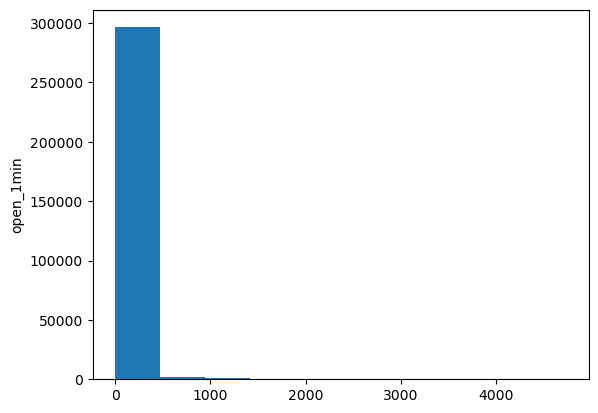

In [54]:
plt.hist(XTRAIN[:,0])
plt.ylabel("open_1min")
plt.show()

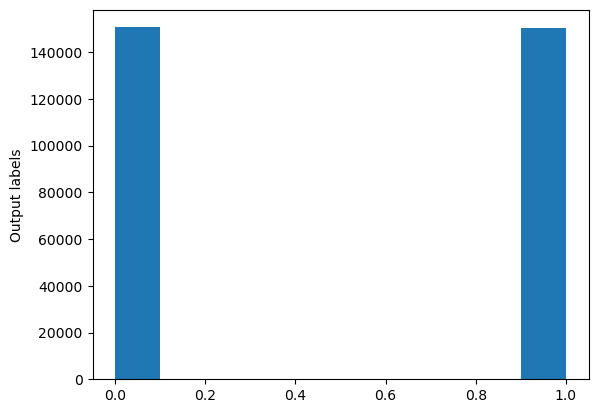

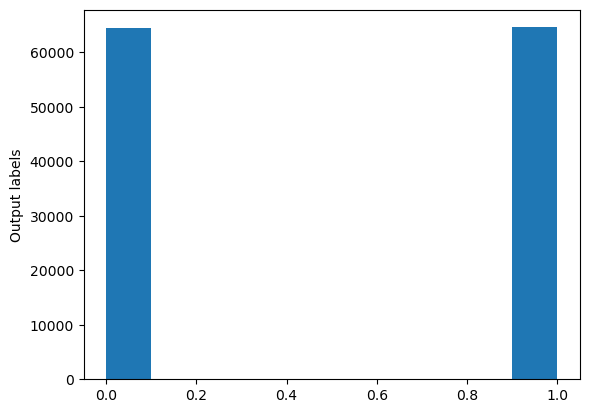

In [55]:
plt.hist(YTRAIN)
plt.ylabel("Output labels")
plt.show()

plt.hist(YVALIDATION)
plt.ylabel("Output labels")
plt.show()

Tenderalization (mean normalization)

In [56]:
mean = XTRAIN.mean(axis=0)
XTRAIN -= mean 
std = XTRAIN.std(axis=0)
XTRAIN /= std

XVALIDATION -=mean
XVALIDATION /= std

In [58]:
Normalization={"mean":mean.tolist(),"std":std.tolist()}
with open('Normalization_Values.json', 'w') as fp:
            json.dump(Normalization, fp,  indent=4)

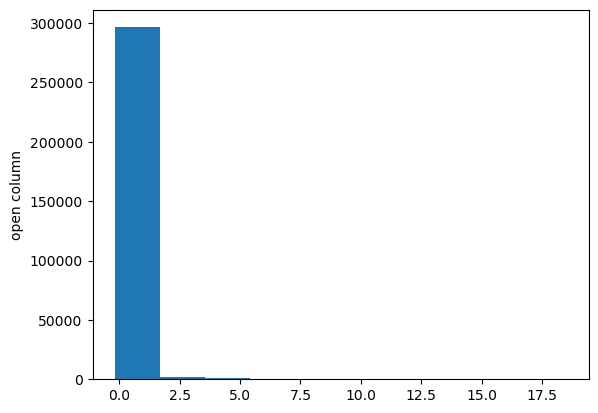

In [59]:
plt.hist(XTRAIN[:,0])
plt.ylabel("open column")
plt.show()

In [60]:
print(XTRAIN.shape)
print(YTRAIN.shape)
print(XVALIDATION.shape)
print(YVALIDATION.shape)

(300958, 747)
(300958,)
(128982, 747)
(128982,)


# Neural network model

### Model Generator

In [61]:
IN_DIM=len(XTRAIN[0,:])

#code genrator
global All_Hist
try:
    with open('Results_history.json') as json_file:
        All_Hist = json.load(json_file)
except:
    All_Hist={0.000001:"code"}

try:
    All_Hist.pop('1e-06')
except:
    print(All_Hist)


The neural network architecture:
- layer 1 : 764 neurons
- layer 2 : 8 neurons
- layer 3 : neurons 

## Model Test

## Compile the model 

In [62]:
model = Sequential()
model.add(Dense(int(IN_DIM/2),input_dim=IN_DIM,activation='softplus'))
model.add(Dense(int(IN_DIM/2),activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(int(IN_DIM/5),activation='softplus'))
model.add(Dense(int(IN_DIM/4),activation='softmax'))
model.add(Dense(int(IN_DIM/1),activation='softplus'))
model.add(Dense(1,activation='sigmoid'))
print(model.summary())
#model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
callbacks_a = ModelCheckpoint(filepath ='XcryptoAi_model.hdf5',monitor ='val_accuracy',save_best_only = True, save_weights = True)
callbacks_b = EarlyStopping(monitor ='val_accuracy',mode='auto',patience=20,verbose=1)
history = model.fit(XTRAIN,
                YTRAIN,
                validation_data=(XVALIDATION,YVALIDATION),
                epochs=1200,
                batch_size=5000,
                callbacks=[callbacks_a,callbacks_b])

print('##########################################################################')
print(f"------val_accuracy-----> {'{0:.4g}'.format(max(history.history['val_accuracy'])*100)} | {'{0:.4g}'.format(max(history.history['accuracy'])*100)} <----------accuracy----------")


61/61 [==============================] - 5s 86ms/step - loss: 0.0487 - accuracy: 0.9822 - val_loss: 0.0746 - val_accuracy: 0.9725
Epoch 69/1200
61/61 [==============================] - 6s 91ms/step - loss: 0.0481 - accuracy: 0.9823 - val_loss: 0.0781 - val_accuracy: 0.9717
Epoch 70/1200
61/61 [==============================] - 5s 82ms/step - loss: 0.0482 - accuracy: 0.9823 - val_loss: 0.0769 - val_accuracy: 0.9727
Epoch 71/1200
61/61 [==============================] - 5s 79ms/step - loss: 0.0465 - accuracy: 0.9830 - val_loss: 0.0764 - val_accuracy: 0.9729
Epoch 72/1200
61/61 [==============================] - 5s 89ms/step - loss: 0.0458 - accuracy: 0.9834 - val_loss: 0.0754 - val_accuracy: 0.9721
Epoch 73/1200
61/61 [==============================] - 5s 80ms/step - loss: 0.0451 - accuracy: 0.9837 - val_loss: 0.0762 - val_accuracy: 0.9724
Epoch 74/1200
61/61 [==============================] - 5s 76ms/step - loss: 0.0474 - accuracy: 0.9828 - val_loss: 0.0749 - val_accuracy: 0.9722
Epoch 

In [63]:
print('##########################################################################')
print(f"------val_accuracy-----> {'{0:.4g}'.format(max(history.history['val_accuracy'])*100)} | {'{0:.4g}'.format(max(history.history['accuracy'])*100)} <----------accuracy----------")


##########################################################################
------val_accuracy-----> 97.36 | 98.84 <----------accuracy----------


In [64]:
accuracy = model.evaluate(XVALIDATION, YVALIDATION)


4031/4031 [==============================] - 97s 24ms/step - loss: 0.0818 - accuracy: 0.9731


In [70]:
dt[0,740:-1]

array([ 1.34755481,  1.54203805, -0.27254662,  0.02283634, -1.37429572,
        0.39523371,  0.08594001])

### Use the model

In [71]:

# make probability predictions with the model
predictions = model.predict(XVALIDATION)
# round predictions 
rounded = [round(x[0]) for x in predictions]

In [78]:
rounded[121201]

0

In [79]:
YVALIDATION[121201]

0.0